In [1]:
%pylab inline
import ROOT, rat
import os, sys, pickle
import jp_mpl as jplot
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


### Loading simplified SOC files

In [2]:
outdir = '/home/jp/projects/snoplus/laserball_calibration/all_runs_pckl'

In [3]:
# Load all the already available files
pfile_list = os.listdir(outdir)
data = []
for one_file in pfile_list:
    print 'Loading ', one_file
    infile = open(os.path.join(outdir, one_file))
    data.append(pickle.load(infile))
    data[-1]['run'] = int(one_file[4:14])
    infile.close()

Loading  SOC_0000100559.pckl
Loading  SOC_0000100560.pckl
Loading  SOC_0000100558.pckl
Loading  SOC_0000017386_reprocessed.pckl
Loading  SOC_0000017375_reprocessed.pckl
Loading  SOC_0000017376_reprocessed.pckl
Loading  SOC_0000017377_reprocessed.pckl
Loading  SOC_0000100554.pckl
Loading  SOC_0000100555.pckl
Loading  SOC_0000100556.pckl
Loading  SOC_0000017384_reprocessed.pckl
Loading  SOC_0000017378_reprocessed.pckl


### Loading the PMT information

In [4]:
pmt_info = pickle.load(open('/home/jp/projects/snoplus/python_modules/pmt_positions.pckl'))

### For each run, load the data quality table

In [11]:
quality_dir = '/home/jp/projects/snoplus/laserball_calibration/pmt_quality_occupancy'
one_run = data[0]
print one_run['run']

100559


In [18]:
qdict = pickle.load(open(os.path.join(quality_dir, str(one_run['run']) + '_PMT_quality.pckl')))

In [73]:
required_keys = ['normal_pmts']
required_keys = ['unobstructed']
required_keys = ['positive']
required_keys = ['positive', 'global_cut']
required_keys = ['positive', 'global_cut', 'nearby_cut']


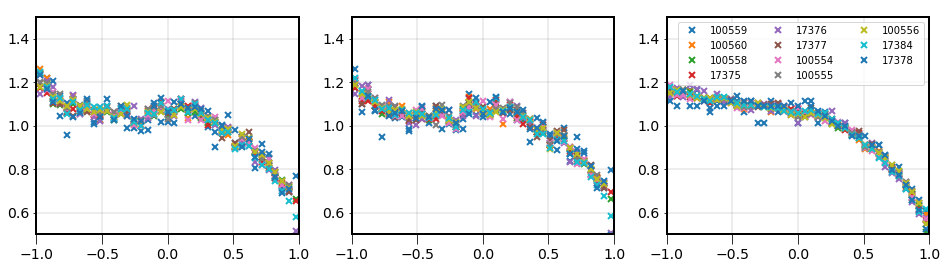

In [74]:
nbins = 39
cos_bins = np.linspace(-1, 1, nbins+1)
cos_centers = (cos_bins[1:] + cos_bins[:-1])/2.
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey=ax1, sharex=ax1)
ax3 = fig.add_subplot(133, sharey=ax2, sharex=ax2)

pos_key = 'vertex' # could use 'calib'

for irun, one_run in enumerate(data):
    
    if np.linalg.norm(one_run[pos_key]) > 400.: 
        # Only accept up to 40 cm in vertex displacement from center
        continue
    
    qdict = pickle.load(open(os.path.join(quality_dir, str(one_run['run']) + '_PMT_quality.pckl')))
    
    valid_pmts = np.ones_like(qdict['normal_pmts'])
    for qkey in required_keys:
        valid_pmts *= qdict[qkey]
    
    one_run['distance'] = np.sqrt(np.sum((pmt_info['xyz'] - one_run[pos_key])**2,axis=1))
    one_run['costheta'] = (pmt_info['xyz'][:,2] - one_run[pos_key][2])/one_run['distance']
    one_run['phi'] = np.arctan2((pmt_info['xyz'][:,1] - one_run[pos_key][1]), 
                                (pmt_info['xyz'][:,0] - one_run[pos_key][0]))
    
    qhs = np.zeros(nbins)
    qhl = np.zeros_like(qhs)
    occ = np.zeros_like(qhs)

    for ibin in range(nbins):
        ipmts = (one_run['costheta']>cos_bins[ibin])*(one_run['costheta']<cos_bins[ibin+1])
        pmt_distance = one_run['distance'][valid_pmts*ipmts]



        qhs[ibin] = one_run['qhs'][valid_pmts*ipmts].mean()
        qhl[ibin] = one_run['qhl'][valid_pmts*ipmts].mean()
        occ[ibin] = one_run['occupancy'][valid_pmts*ipmts].mean() 
        
        qhs[ibin] = np.median(one_run['qhs'][valid_pmts*ipmts])
        qhl[ibin] = np.median(one_run['qhl'][valid_pmts*ipmts])
        occ[ibin] = np.median(one_run['occupancy'][valid_pmts*ipmts])


    #print rqhs, rqhl, rocc
    ax1.plot(cos_centers, qhs/qhs.mean(), 'x', label = one_run['run'])
    ax2.plot(cos_centers, qhl/qhl.mean(), 'x', label = one_run['run'])
    ax3.plot(cos_centers, occ/occ.mean(), 'x', label = one_run['run'])
ax1.set_ylim(0.5, 1.5)
ax1.set_xlim(-1, 1.)



plt.legend(loc=0,ncol=3)